This notebook is to export $\Delta$-rank heatmaps.

Import the necessary libraries, and specify the analyzed datasets to use. Here, we use the `Combined` validation set and $T=1$.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
from typing import Callable, TypeAlias

# Constants
SETTING_PATH = "draw-figures-settings.json"
DB_PATHS = {
    "Random": "outputs-reproduce/cov-wt-outputs/random/wt2combined-(t-1.00).csv",
    "Hie-BiLSTM": "outputs-reproduce/cov-wt-outputs/hie/wt2combined-(t-1.00).csv",
    "ESM2-150M-DMS": "outputs-reproduce/cov-wt-outputs/esm2-150m-cos/wt2combined-(t-1.00).csv",
    "ESM2-650M-DMS": "outputs-reproduce/cov-wt-outputs/esm2-650m-cos/wt2combined-(t-1.00).csv",
    "ESM2-3B-DMS": "outputs-reproduce/cov-wt-outputs/esm2-3b-cos/wt2combined-(t-1.00).csv",
}

Load setting file.

In [2]:
# Read the settings
assert os.path.exists(SETTING_PATH), "Setting file does not exist!"
with open(SETTING_PATH, "r") as f:
    settings = json.load(f)

Define various averaging functions.

In [3]:
MovingFilter: TypeAlias = Callable[[np.ndarray, int, int | float], float]


def moving_avg(data, pos: int, width: int = 5):
    data_part = data[max(pos - width, 0) : min(pos + width, len(data))]
    return np.mean(data_part)


def gaussian_avg(data, pos: int, width: float = 5.0):
    filter = np.exp(-((np.arange(len(data)) - pos) ** 2) / (2 * width**2))
    filtered = data * filter
    return np.sum(filtered) / np.sum(filter)

Dataset: Random
Min: -1997.68203648478
Max: 2452.5291012773796

Dataset: Hie-BiLSTM
Min: -7836.807882717207
Max: 4564.574084932846

Dataset: ESM2-150M-DMS
Min: -4708.534483163365
Max: 5922.139404048776

Dataset: ESM2-650M-DMS
Min: -5171.8887402896235
Max: 6648.145781462824

Dataset: ESM2-3B-DMS
Min: -5615.850414524949
Max: 6648.882466402437



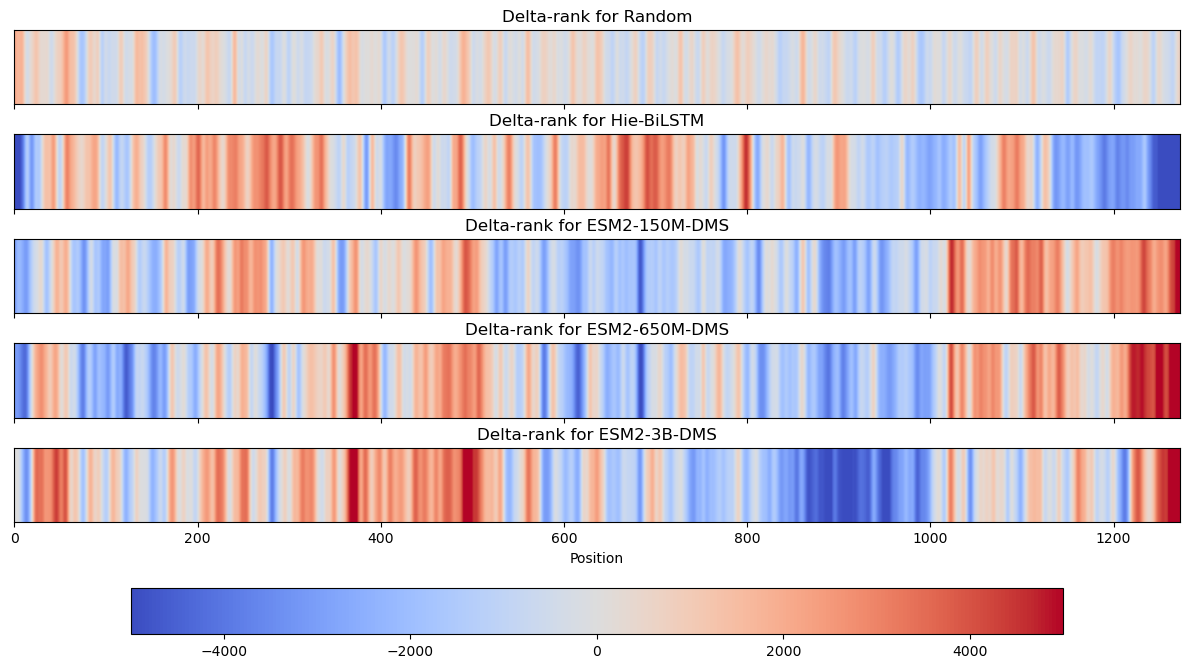

In [4]:
# Settings
vrange = 5000  # Set range for the color scale to (-vrange, vrange)
avg_f: MovingFilter = gaussian_avg  # Choose the averaging function
avg_w = 2.5  # Width for the averaging function, can be an integer or float, depending on the function used


# Generate subplots for each dataset
fig, axes = plt.subplots(len(DB_PATHS), 1, figsize=(12, 1.5 * len(DB_PATHS)), sharex=True)
if len(DB_PATHS) == 1:
    axes = [axes]  # Ensure axes is always a list for single subplot case


for i, (label, path) in enumerate(DB_PATHS.items()):
    # Read the CSV file and calculate the delta rank
    df = pd.read_csv(path)
    df["delta_rank"] = df["cacscs"] - df["rank_cscs"]
    delta_mean = df.groupby("pos")["delta_rank"].mean()
    delta_mean = delta_mean.to_numpy()

    # Apply the averaging function to the delta rank values
    delta_mean_avg = np.array([avg_f(delta_mean, i, avg_w) for i in range(len(delta_mean))])

    # Plot the delta rank heatmap
    im = axes[i].imshow(
        delta_mean_avg.reshape(1, -1),
        cmap="coolwarm",
        vmin=-vrange,
        vmax=vrange,
        aspect="auto",
    )
    axes[i].set_title(f"Delta-rank for {label}")
    axes[i].set_yticks([], [])

    # Print the min and max values for each dataset
    print(f"Dataset: {label}")
    print(f"Min: {np.min(delta_mean_avg)}")
    print(f"Max: {np.max(delta_mean_avg)}")
    print()

# Axes and labels
if settings["erase-ticks"]:
    for ax in axes:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
else:
    axes[-1].set_xlabel("Position")
# Tighten the layout
plt.tight_layout()
# Add a colorbar to the last subplot
fig.colorbar(im, ax=axes, orientation="horizontal", pad=0.1, shrink=0.8)

# Save the figure to the specified directory
plt.savefig("outputs-figures/cov-wt/delta-rank-combined.pdf", bbox_inches="tight", dpi=600)
plt.show()